# Forecasting Website Traffic Case Study

## Project Description 
This project aims to predict website traffic over a specific period using time series forecasting.

This traffic data was collected from hecleverprogrammer.com between June 2021 and June 2022. The dataset was downloaded from [here](https://statso.io/forecasting-website-traffic-case-study/), and in this project, I will use this data to train a model that predicts website traffic using Python.
___

## Environment set-up

In [28]:
# import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

___
## Data Wrangling 

In [29]:
#Load Data
df = pd.read_csv('Thecleverprogrammer.csv')

#check data
df

,Date,Views
0,01/06/2021,7831
1,02/06/2021,7798
2,03/06/2021,7401
3,04/06/2021,7054
4,05/06/2021,7973
...,...,...
386,22/06/2022,11154
387,23/06/2022,10382
388,24/06/2022,9555
389,25/06/2022,8502


The dataset contains two columns, date and traffic. I will convert the date column to date and time data type.

In [30]:
# convert the 'date' column to datetime format

df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

#check data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391 entries, 0 to 390
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    391 non-null    datetime64[ns]
 1   Views   391 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.2 KB


In [31]:
# display the number of rows and columns in the dataset

df.shape

(391, 2)

In [32]:
#check data nulls
df.isnull().sum()

Date     0
Views    0
dtype: int64

In [33]:
#check for duplicated rows
df.duplicated().sum()

np.int64(0)

___

##  Website Traffic EDA

**Let's take a look at the daily traffic of the site.**

In [34]:
fig = px.line(df, x='Date', y='Views', title='Daily Traffic of Thecleverprogrammer.com')
fig.show()

- The line graph displays the website's daily viewership data from June 2021 to June 2022. The graph reveals significant fluctuations in traffic, with noticeable peaks and troughs over the observed period. High points, such as those reaching around 12,000 views, likely correspond to days with new content releases, promotions, or external events driving increased visitor engagement. Conversely, lower points, dipping to approximately 4,000 views, may indicate weekends, holidays, or periods of reduced activity. The data also suggests possible weekly and seasonal patterns, with traffic often spiking on weekdays and declining on weekends. Over the long term, the graph shows a gradual increase in traffic, particularly from March to May 2022, which could reflect growing audience interest or successful marketing efforts.

**Let's take a look at whether the data is stationary or seasonal.**

In [35]:
# Perform seasonal decomposition
result = seasonal_decompose(df['Views'], model='multiplicative', period=30)

# Create a subplot with 4 charts (Original Data, Trend, Seasonality, Residuals)
fig = make_subplots(rows=4, cols=1, 
                    shared_xaxes=True, 
                    subplot_titles=['Original Data', 'Trend', 'Seasonality', 'Residuals'])

# Original data
fig.add_trace(go.Scatter(x=df['Date'], y=df['Views'], 
                         mode='lines', name='Original'), row=1, col=1)

# Trend component
fig.add_trace(go.Scatter(x=df['Date'], y=result.trend, 
                         mode='lines', name='Trend'), row=2, col=1)

# Seasonality component
fig.add_trace(go.Scatter(x=df['Date'], y=result.seasonal, 
                         mode='lines', name='Seasonality'), row=3, col=1)

# Residuals component
fig.add_trace(go.Scatter(x=df['Date'], y=result.resid, 
                         mode='lines', name='Residuals'), row=4, col=1)

# Improve layout
fig.update_layout(height=900, width=1000, title_text='Seasonal Decomposition of Views')

# Show interactive plot
fig.show()


- The seasonal decomposition analysis of the website traffic data reveals important patterns about its underlying structure. The trend component shows a clear upward trajectory over time, starting from around 7,000-8,000 daily views in mid-2021 and gradually increasing to approximately 9,000 views by early 2022, indicating steady growth in audience engagement. This growth could be attributed to factors like content expansion, improved marketing strategies, or increasing brand recognition. The seasonal component demonstrates regular, repeating patterns that likely correspond to weekly cycles, with noticeable peaks and troughs occurring at consistent intervals. These fluctuations, which show about a 5% variation from the trend, probably reflect higher traffic during weekdays compared to weekends. The residuals, representing random noise in the data, contain some significant outliers that may correspond to exceptional events such as viral content spikes or technical disruptions. This analysis confirms that the time series is both non-stationary (due to the evident trend) and seasonal, suggesting that forecasting models would need to incorporate both these characteristics for accurate predictions. A multiplicative decomposition model was appropriately used here as the seasonal variations appear to scale with the overall trend magnitude.

**I will use the Seasonal ARIMA (SARIMA) model to predict website visits. Before using the SARIMA model, it is necessary to find the values of p, d, and q. Since the data is not stationary, the value of d is 1. To find the values of p and q, we can use autocorrelation and partial autocorrelation plots".**

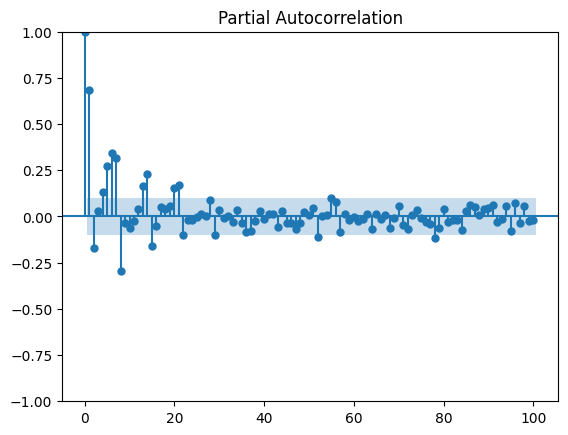

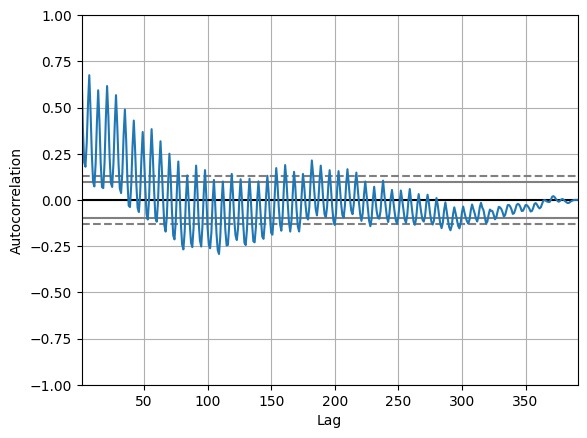

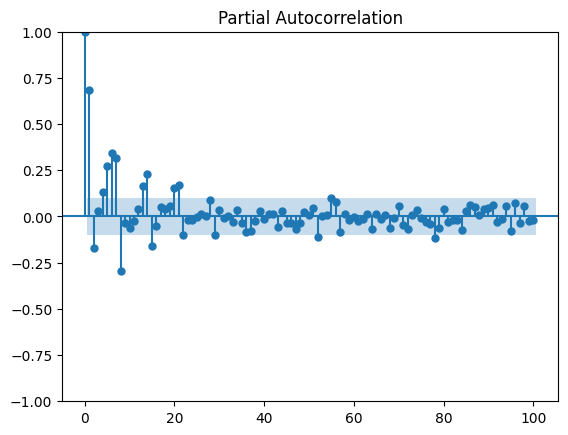

In [36]:
pd.plotting.autocorrelation_plot(df["Views"])
plot_pacf(df["Views"], lags = 100)

- The values p,d,q were determined based on the analysis of the autocorrelation (ACF) and partial autocorrelation (PACF) plots. The differencing value, d=1 was chosen because the data was found to be non-stationary, meaning a stationarity test (such as the ADF test) likely indicated the need for first-order differencing. The value of q=2, which represents the order of the Moving Average (MA) component, was selected based on the ACF plot, where significant spikes were observed up to lag 2 before tapering off. Similarly, the value of p=5, representing the order of the Autoregressive (AR) component, was chosen from the PACF plot, where a sharp cutoff was visible at lag 5. These values suggest that a SARIMA model with parameters (5,1,2) would be appropriate for forecasting, although further tuning using techniques like Grid Search or AIC/BIC optimization could improve accuracy.

____

**We need to train the model to be able to predict traffic in the coming period.**

In [37]:
# Define SARIMA parameters based on your analysis
p = 5
d = 1
q = 2

# Fit SARIMA model
model = sm.tsa.statespace.SARIMAX(df['Views'], order=(p, d, q), seasonal_order=(p, d, q, 12))
model = model.fit()

# Summarize model
print(model.summary())

c:\Users\Bassam\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\Bassam\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                     SARIMAX Results                                      
Dep. Variable:                              Views   No. Observations:                  391
Model:             SARIMAX(5, 1, 2)x(5, 1, 2, 12)   Log Likelihood               -3099.392
Date:                            Thu, 03 Apr 2025   AIC                           6228.783
Time:                                    04:56:48   BIC                           6287.807
Sample:                                         0   HQIC                          6252.209
                                            - 391                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7848      0.132      5.942      0.000       0.526       1.044
ar.L2         -0.7890      0.135   

Let's predict the site's traffic over the next 50 days

In [39]:
predictions = model.predict(len(df), len(df)+50)
print(predictions)

391     9858.572716
392    10776.990425
393    10764.696284
394     9861.103143
395     8753.303832
396     8213.451612
397     8919.741668
398     9681.620622
399    10252.282040
400    10632.037095
401     9860.589856
402     9356.428086
403     9028.873433
404     9065.119317
405    10538.019523
406    10999.546847
407    10902.534851
408    10101.316657
409     9452.586356
410     8619.296604
411     9166.739116
412    10386.340678
413    10587.312657
414    10777.676525
415    10253.588108
416     9450.607975
417     9022.596833
418     9134.384340
419     9858.494887
420    10206.607321
421    10709.309532
422     9903.520909
423     9538.527868
424     9044.552359
425     8788.425520
426    10103.508473
427    10819.884278
428    10901.535294
429    10418.347396
430     9447.977289
431     8673.882593
432     8696.071779
433    10032.275240
434    10488.529045
435    10832.415897
436    10494.184836
437     9339.140004
438     9151.463654
439     9318.450111
440    10265.061181


## Conclusion

- **Website traffic follows a clear upward trend**, with daily views increasing from approximately 7,000 in mid-2021 to around 9,000 by early 2022, reflecting steady audience growth. This growth can be attributed to successful content expansion, marketing strategies, and increasing user engagement.  
- **Seasonality is evident in the data**, with regular weekly patterns showing higher traffic during weekdays and declines on weekends. Peaks, such as reaching 12,000 views, are likely associated with new content releases or promotions, while troughs correspond to lower engagement periods like weekends or holidays.  
- **The time series data is non-stationary and exhibits strong seasonality**, as confirmed by seasonal decomposition. The multiplicative model effectively captures scaling seasonal fluctuations alongside the trend, revealing about a 5% variation in traffic around the baseline.  
- **Key SARIMA parameters (p=5, d=1, q=2)** were chosen based on autocorrelation (ACF) and partial autocorrelation (PACF) analysis. These parameters capture the time series' underlying structure, incorporating both the trend and seasonal components for accurate forecasting.  
- **The SARIMA model is capable of predicting website traffic**, offering a reliable means to anticipate future trends. 

> **"This project was entirely developed by **Bassam El-Shoraa**"**.